# Market Regime Detection in a Multi Asset ETF Universe

This notebook explores how global market conditions can be understood through unsupervised learning.  
Using a universe of 27 exchange traded funds spanning equities, bonds, commodities, credit, and global exposures, we extract features, reduce dimensionality, and identify market regimes through clustering.


## 1. Data Import and Preparation

We begin by loading 27 ETFs which represent the main global asset classes.  
The goal of this project is to examine how these assets behave collectively across time and whether their joint behavior forms identifiable market regimes.

The dataset includes:
- daily prices  
- net asset values  
- broad coverage of major asset classes  


In [13]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

df = pd.read_excel('./DATA.xlsx', sheet_name=None)
indexes = list(df.keys())

## 2. Feature Engineering

Market regimes are driven by changes in volatility, trend, liquidity, and cross asset relationships.  
To capture these dynamics I compute a set of features that summarize the state of each asset.

The main features include:
- daily returns  
- twenty day realized volatility  
- twenty day momentum, defined as the twenty day return  
- drawdown depth over a twenty day window  
- NAV premium, defined as (price minus NAV) divided by NAV  
- rolling premium volatility  
- rolling correlations across selected pairs  
- PCA factors as compressed representations of the entire feature space

These features encode information about risk, trend, liquidity, and market stress which are essential inputs for regime detection.


In [ ]:
for index in indexes:
    df[index] = df[index].dropna()
    df[index] = df[index].set_index("Date")
    df[index]['20DayVol'] = df[index]['Price'].rolling(window=20).std()
    df[index]['60DayVol'] = df[index]['Price'].rolling(window=60).std()
    df[index]['VoV30'] = df[index]['20DayVol'].rolling(window=30).std()
    
    df[index]['Return'] = df[index]['Price'].pct_change()
    df[index]['Mom20'] = df[index]['Price'] / df[index]['Price'].shift(20) - 1
    df[index]['ReSkew'] = df[index]['Return'].rolling(20).skew()
    df[index]['20DayMax'] = df[index]['Price'].rolling(20).max()
    df[index]['20DayDrawdown'] = df[index]['Price'] / df[index]['20DayMax'] - 1

    df[index]['Premium'] = (df[index]['Price'] - df[index]['NAV']) / df[index]['NAV']
    r30mean = df[index]['Premium'].rolling(window=30).mean()
    r30sigma = df[index]['Premium'].rolling(window=30).std()
    df[index]['Z-score'] = (df[index]['Premium'] - r30mean) / r30sigma
    df[index]['Prem20DVol'] = df[index]['Premium'].rolling(20).std()
    df[index]['PremDiff'] = df[index]['Premium'].diff()


Example for S&P 500

In [15]:
df['SPY']

,Price,NAV,Volume,AUM,20DayVol,60DayVol,VoV30,Return,Mom20,ReSkew,20DayMax,20DayDrawdown,Premium,Z-score,Prem20DVol,PremDiff
Date,,,,,,,,,,,,,,,,
2017-01-03,225.24,225.1840,91366522.0,230166.8000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000249,NaN,NaN,NaN
2017-01-04,226.58,226.5240,78744433.0,229740.5000,NaN,NaN,NaN,0.005949,NaN,NaN,NaN,NaN,0.000247,NaN,NaN,-0.000001
2017-01-05,226.40,226.3490,78379012.0,229529.5000,NaN,NaN,NaN,-0.000794,NaN,NaN,NaN,NaN,0.000225,NaN,NaN,-0.000022
2017-01-06,227.21,227.2160,71559922.0,226433.2000,NaN,NaN,NaN,0.003578,NaN,NaN,NaN,NaN,-0.000026,NaN,NaN,-0.000252
2017-01-09,226.46,226.4150,46939676.0,226876.3000,NaN,NaN,NaN,-0.003301,NaN,NaN,NaN,NaN,0.000199,NaN,NaN,0.000225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,670.31,669.9502,85035298.0,692749.9724,9.672770,13.431737,1.780589,-0.010729,-0.001266,-1.022706,687.39,-0.024848,0.000537,1.574911,0.000275,0.000440
2025-11-07,670.97,670.8581,100592443.0,692447.7505,8.503204,13.324246,1.804703,0.000985,0.027488,-0.235496,687.39,-0.023887,0.000167,0.077466,0.000272,-0.000370
2025-11-10,681.44,681.2638,75842888.0,701519.2624,8.282294,13.357357,1.824295,0.015604,0.027751,-0.218043,687.39,-0.008656,0.000259,0.441741,0.000252,0.000092


## 3. Dimensionality Reduction with PCA

The feature matrix contains many variables which can introduce noise and redundancy.  
Principal Component Analysis reduces the dimensionality by identifying the primary directions of variation in the data.

Key points:
- the first several principal components capture a significant portion of cross asset behavior  
- even if the total explained variance is moderate, the leading components summarize the major macro forces  
- PCA helps stabilize clustering and highlights common drivers such as global risk appetite, duration sensitivity, and commodity trends


Initially, I flatten the dimention of the dataset

In [16]:
cols = ["20DayVol", "60DayVol", "VoV30", "Mom20", "ReSkew", "20DayDrawdown", "Premium", "Z-score", "Prem20DVol", "PremDiff"]

dfs_filtered = {name: df[cols] for name, df in df.items()}
dfs_prefixed = {name: df.add_prefix(f"{name}_") for name, df in dfs_filtered.items()}

big_df = pd.concat(dfs_prefixed.values(), axis=1).dropna()
big_df

,SPY_20DayVol,SPY_60DayVol,SPY_VoV30,SPY_Mom20,SPY_ReSkew,SPY_20DayDrawdown,SPY_Premium,SPY_Z-score,SPY_Prem20DVol,SPY_PremDiff,...,SOXX_20DayVol,SOXX_60DayVol,SOXX_VoV30,SOXX_Mom20,SOXX_ReSkew,SOXX_20DayDrawdown,SOXX_Premium,SOXX_Z-score,SOXX_Prem20DVol,SOXX_PremDiff
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-29,1.753902,4.600204,0.909508,-0.017683,-0.286279,-0.014271,-0.000115,-0.217111,0.000319,-0.000348,...,0.575638,1.431995,0.092010,0.019999,-1.708201,-0.008518,0.000000,0.033622,0.000201,0.000000
2017-03-30,1.700322,4.535769,0.917548,-0.008310,-0.513920,-0.011132,0.000110,0.600224,0.000299,0.000225,...,0.557543,1.414333,0.083108,0.035871,-2.154776,-0.003420,-0.000072,-0.303486,0.000202,-0.000072
2017-03-31,1.632219,4.489495,0.925370,-0.011241,-0.407649,-0.013434,0.000042,0.342920,0.000284,-0.000068,...,0.524242,1.395780,0.080119,0.036497,-2.175450,-0.003348,0.000292,1.191091,0.000208,0.000364
2017-04-03,1.603494,4.428712,0.930218,-0.010012,-0.452067,-0.015150,-0.000098,-0.175061,0.000283,-0.000140,...,0.466706,1.353693,0.079111,0.029362,-1.907927,-0.009683,-0.000514,-2.025867,0.000243,-0.000805
2017-04-04,1.594062,4.382448,0.929392,-0.006414,-0.584089,-0.014522,-0.000174,-0.461051,0.000278,-0.000076,...,0.403277,1.314120,0.080788,0.021974,-1.686351,-0.014634,-0.000222,-0.838345,0.000231,0.000292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,9.672770,13.431737,1.780589,-0.001266,-1.022706,-0.024848,0.000537,1.574911,0.000275,0.000440,...,10.506598,21.104773,0.862676,0.025190,-0.602674,-0.039083,0.000891,1.766374,0.000631,0.001092
2025-11-07,8.503204,13.324246,1.804703,0.027488,-0.235496,-0.023887,0.000167,0.077466,0.000272,-0.000370,...,9.053294,21.179786,0.857590,0.082319,-0.069221,-0.049160,0.000234,0.502380,0.000585,-0.000657
2025-11-10,8.282294,13.357357,1.824295,0.027751,-0.218043,-0.008656,0.000259,0.441741,0.000252,0.000092,...,8.770100,21.284459,0.857346,0.060133,-0.368829,-0.024548,-0.000758,-1.269290,0.000562,-0.000992


#### 3.1. Running the PCA

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
bdfs = pd.DataFrame(scaler.fit_transform(big_df), columns=big_df.columns, index=big_df.index)

X_scaled = scaler.fit_transform(big_df)
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

In [18]:
pca_df = pd.DataFrame(
    X_pca,
    columns=[f"pc{i + 1}" for i in range(8)],
    index=big_df.index
)
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
Date,,,,,,,,
2017-03-29,-5.070675,-2.099596,6.362990,-0.342151,0.205238,3.176286,-0.433355,0.979791
2017-03-30,-5.178414,-2.340093,6.201789,-1.143304,-0.303529,1.468435,-0.307813,-0.604092
2017-03-31,-5.228427,-1.997864,6.671012,1.181776,-0.190521,1.836865,-0.352274,0.584558
2017-04-03,-5.421689,-1.456502,6.681415,1.264099,-0.041006,2.808459,-0.500346,1.414643
2017-04-04,-5.537938,-2.094918,6.301319,0.850828,-0.805446,1.166142,-0.716074,-0.191595
...,...,...,...,...,...,...,...,...
2025-11-06,-0.082957,-0.041219,-6.476083,-2.774981,-1.892204,4.050548,-7.343660,-3.075727
2025-11-07,-1.047789,2.185609,-6.302002,1.525849,-2.941173,0.401792,-4.423638,-3.023827
2025-11-10,-1.999345,3.169502,-5.454247,2.954041,-2.679290,1.713822,-5.089020,-1.457556


In [19]:
pca.explained_variance_ratio_

array([0.20495593, 0.0858654 , 0.05886619, 0.04090948, 0.03264391,
       0.0286786 , 0.02700297, 0.01974795])

In [20]:
pca.explained_variance_ratio_.sum()


np.float64(0.498670427082213)

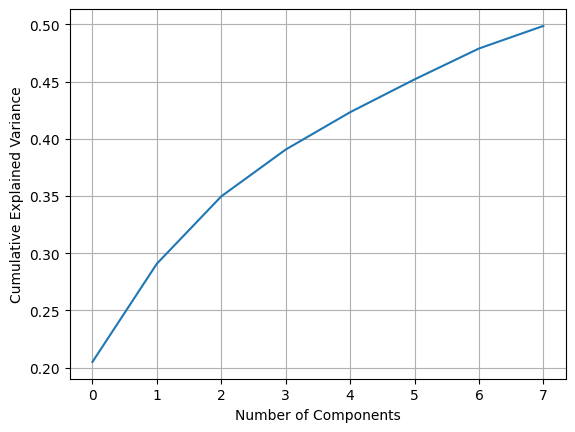

In [21]:
import matplotlib.pyplot as plt

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


You can see that PCA is not explaining a lot of variance. However, for the sake of this analysis, we do not need 60 or 70 PCs to reach a high variance (you can tweak the parameters if you want to see) because our main goal is to identify three regimes in the markets in a fast and efficient way. In that case, it is not productive to take a lot of PCs.

## 4. Clustering Market Regimes with K Means

Nex, I apply K Means clustering to the reduced feature matrix to discover distinct market regimes.  
This method groups days with similar market characteristics without relying on prior labels.

The output of K Means is:
- a set of regime labels, which I incorporate to the big dataframe
- regime centroids which represent typical feature values  
- a partition of the historical period into separate states

These regimes can represent environments such as:
- risk on  
- risk off  
- inflation or commodity driven conditions  
- volatility expansions or contractions  

The clusters serve as a foundation for analyzing asset performance across market states.


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pca_sets = {k: X_pca[:, :k] for k in range(3, 9)}

kmeans_results = {}
for pcs, X_sub in pca_sets.items():
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_sub)
    kmeans_results[pcs] = clusters

scores = {}
for pcs, X_sub in pca_sets.items():
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(X_sub)
    score = silhouette_score(X_sub, labels)
    scores[pcs] = score
    print(f"{pcs} PCs → Silhouette: {score:.4f}")


3 PCs → Silhouette: 0.3249
4 PCs → Silhouette: 0.2790
5 PCs → Silhouette: 0.2404
6 PCs → Silhouette: 0.2160
7 PCs → Silhouette: 0.2014
8 PCs → Silhouette: 0.2590


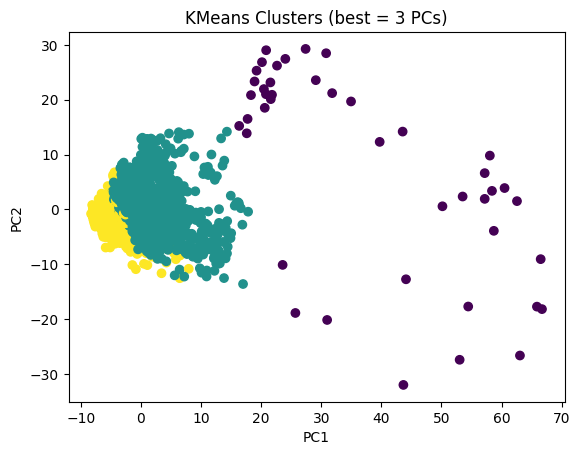

In [ ]:
import matplotlib.pyplot as plt

best_pcs = max(scores, key=scores.get)
best_labels = kmeans_results[best_pcs]
big_df["cluster"] = best_labels

plt.scatter(X_pca[:,0], X_pca[:,1], c=best_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans Clusters (best = {best_pcs} PCs)")
plt.show()


In [ ]:
pca = PCA(n_components=3)
X_pca3 = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca3)
big_df["Regimes"] = labels

## 5. Asset Performance within Each Regime

We evaluate how each ETF behaves inside the regimes.  
For each asset and each regime we compute:

- average daily return  
- volatility  
- Sharpe ratio  
- drawdown characteristics  

This analysis reveals which assets perform best in risk on environments, which act as hedges in risk off conditions, and which respond to inflation or commodity driven states.

The results highlight how regime classification connects to practical asset allocation decisions.


In [31]:
returns = {}
vol20 = {}
for index in indexes:
    r = [0,0,0]
    r[0] += df[index].loc[big_df[big_df['Regimes'] == 0].index]['Return'].mean()
    r[1] += df[index].loc[big_df[big_df['Regimes'] == 1].index]['Return'].mean()
    r[2] += df[index].loc[big_df[big_df['Regimes'] == 2].index]['Return'].mean()
    returns[index] = r

    v = [0,0,0]
    v[0] += df[index].loc[big_df[big_df['Regimes'] == 0].index]['20DayVol'].mean()
    v[1] += df[index].loc[big_df[big_df['Regimes'] == 1].index]['20DayVol'].mean()
    v[2] += df[index].loc[big_df[big_df['Regimes'] == 2].index]['20DayVol'].mean()
    vol20[index] = v


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

returns_df = pd.DataFrame(returns, index=['Regime 0', 'Regime 1', 'Regime 2'])
vol_df = pd.DataFrame(vol20, index=['Regime 0', 'Regime 1', 'Regime 2'])


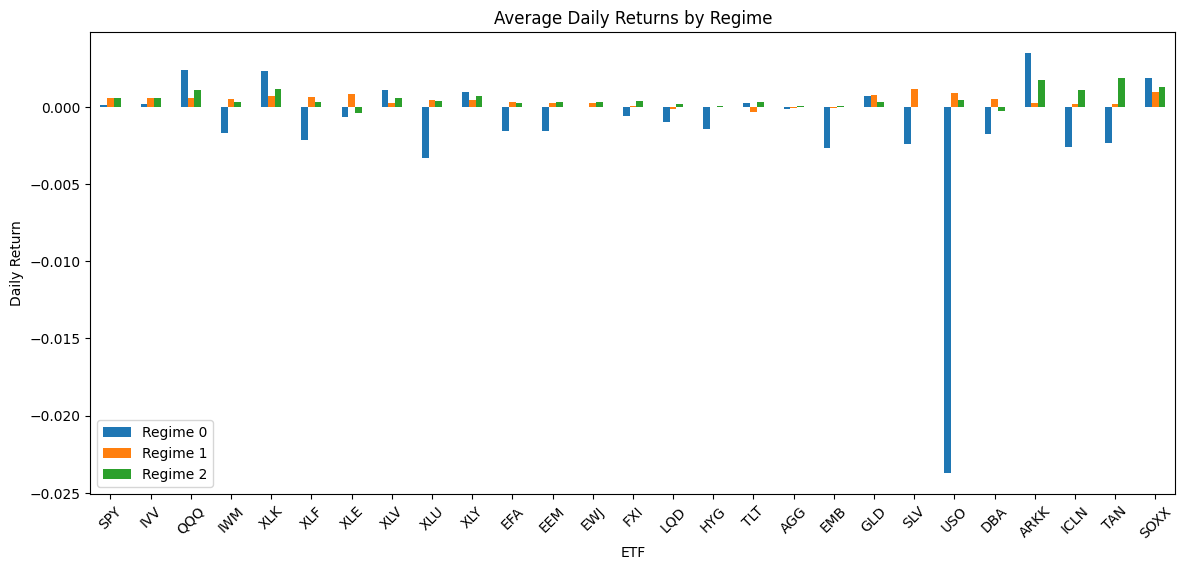

In [47]:
returns_df.T.plot(kind='bar', figsize=(14,6))
plt.title("Average Daily Returns by Regime")
plt.ylabel("Daily Return")
plt.xlabel("ETF")
plt.xticks(rotation=45)
plt.show()


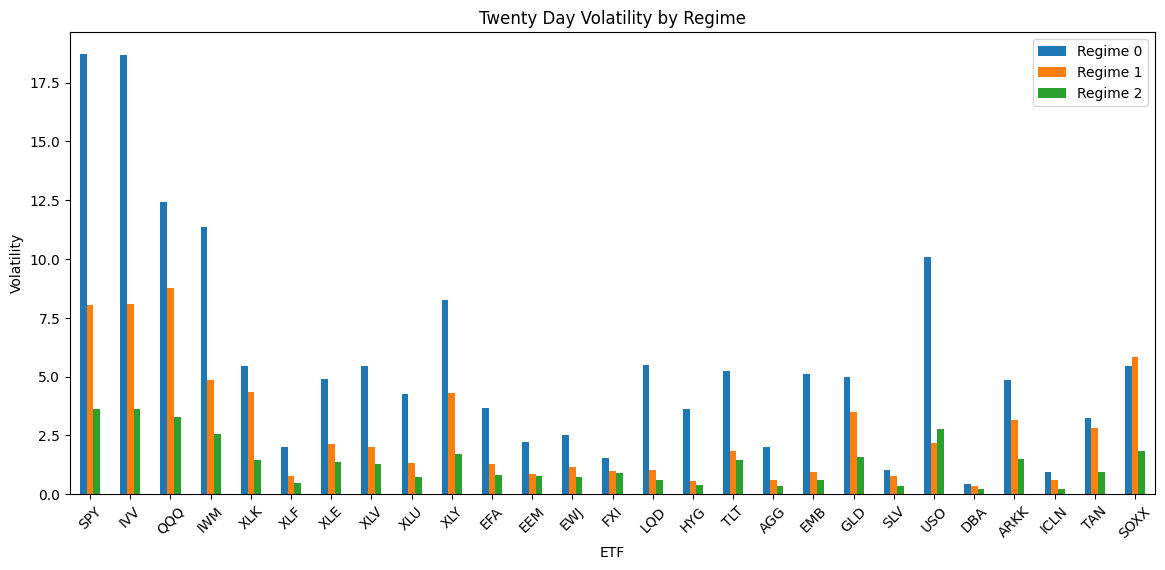

In [48]:
vol_df.T.plot(kind='bar', figsize=(14,6))
plt.title("Twenty Day Volatility by Regime")
plt.ylabel("Volatility")
plt.xlabel("ETF")
plt.xticks(rotation=45)
plt.show()


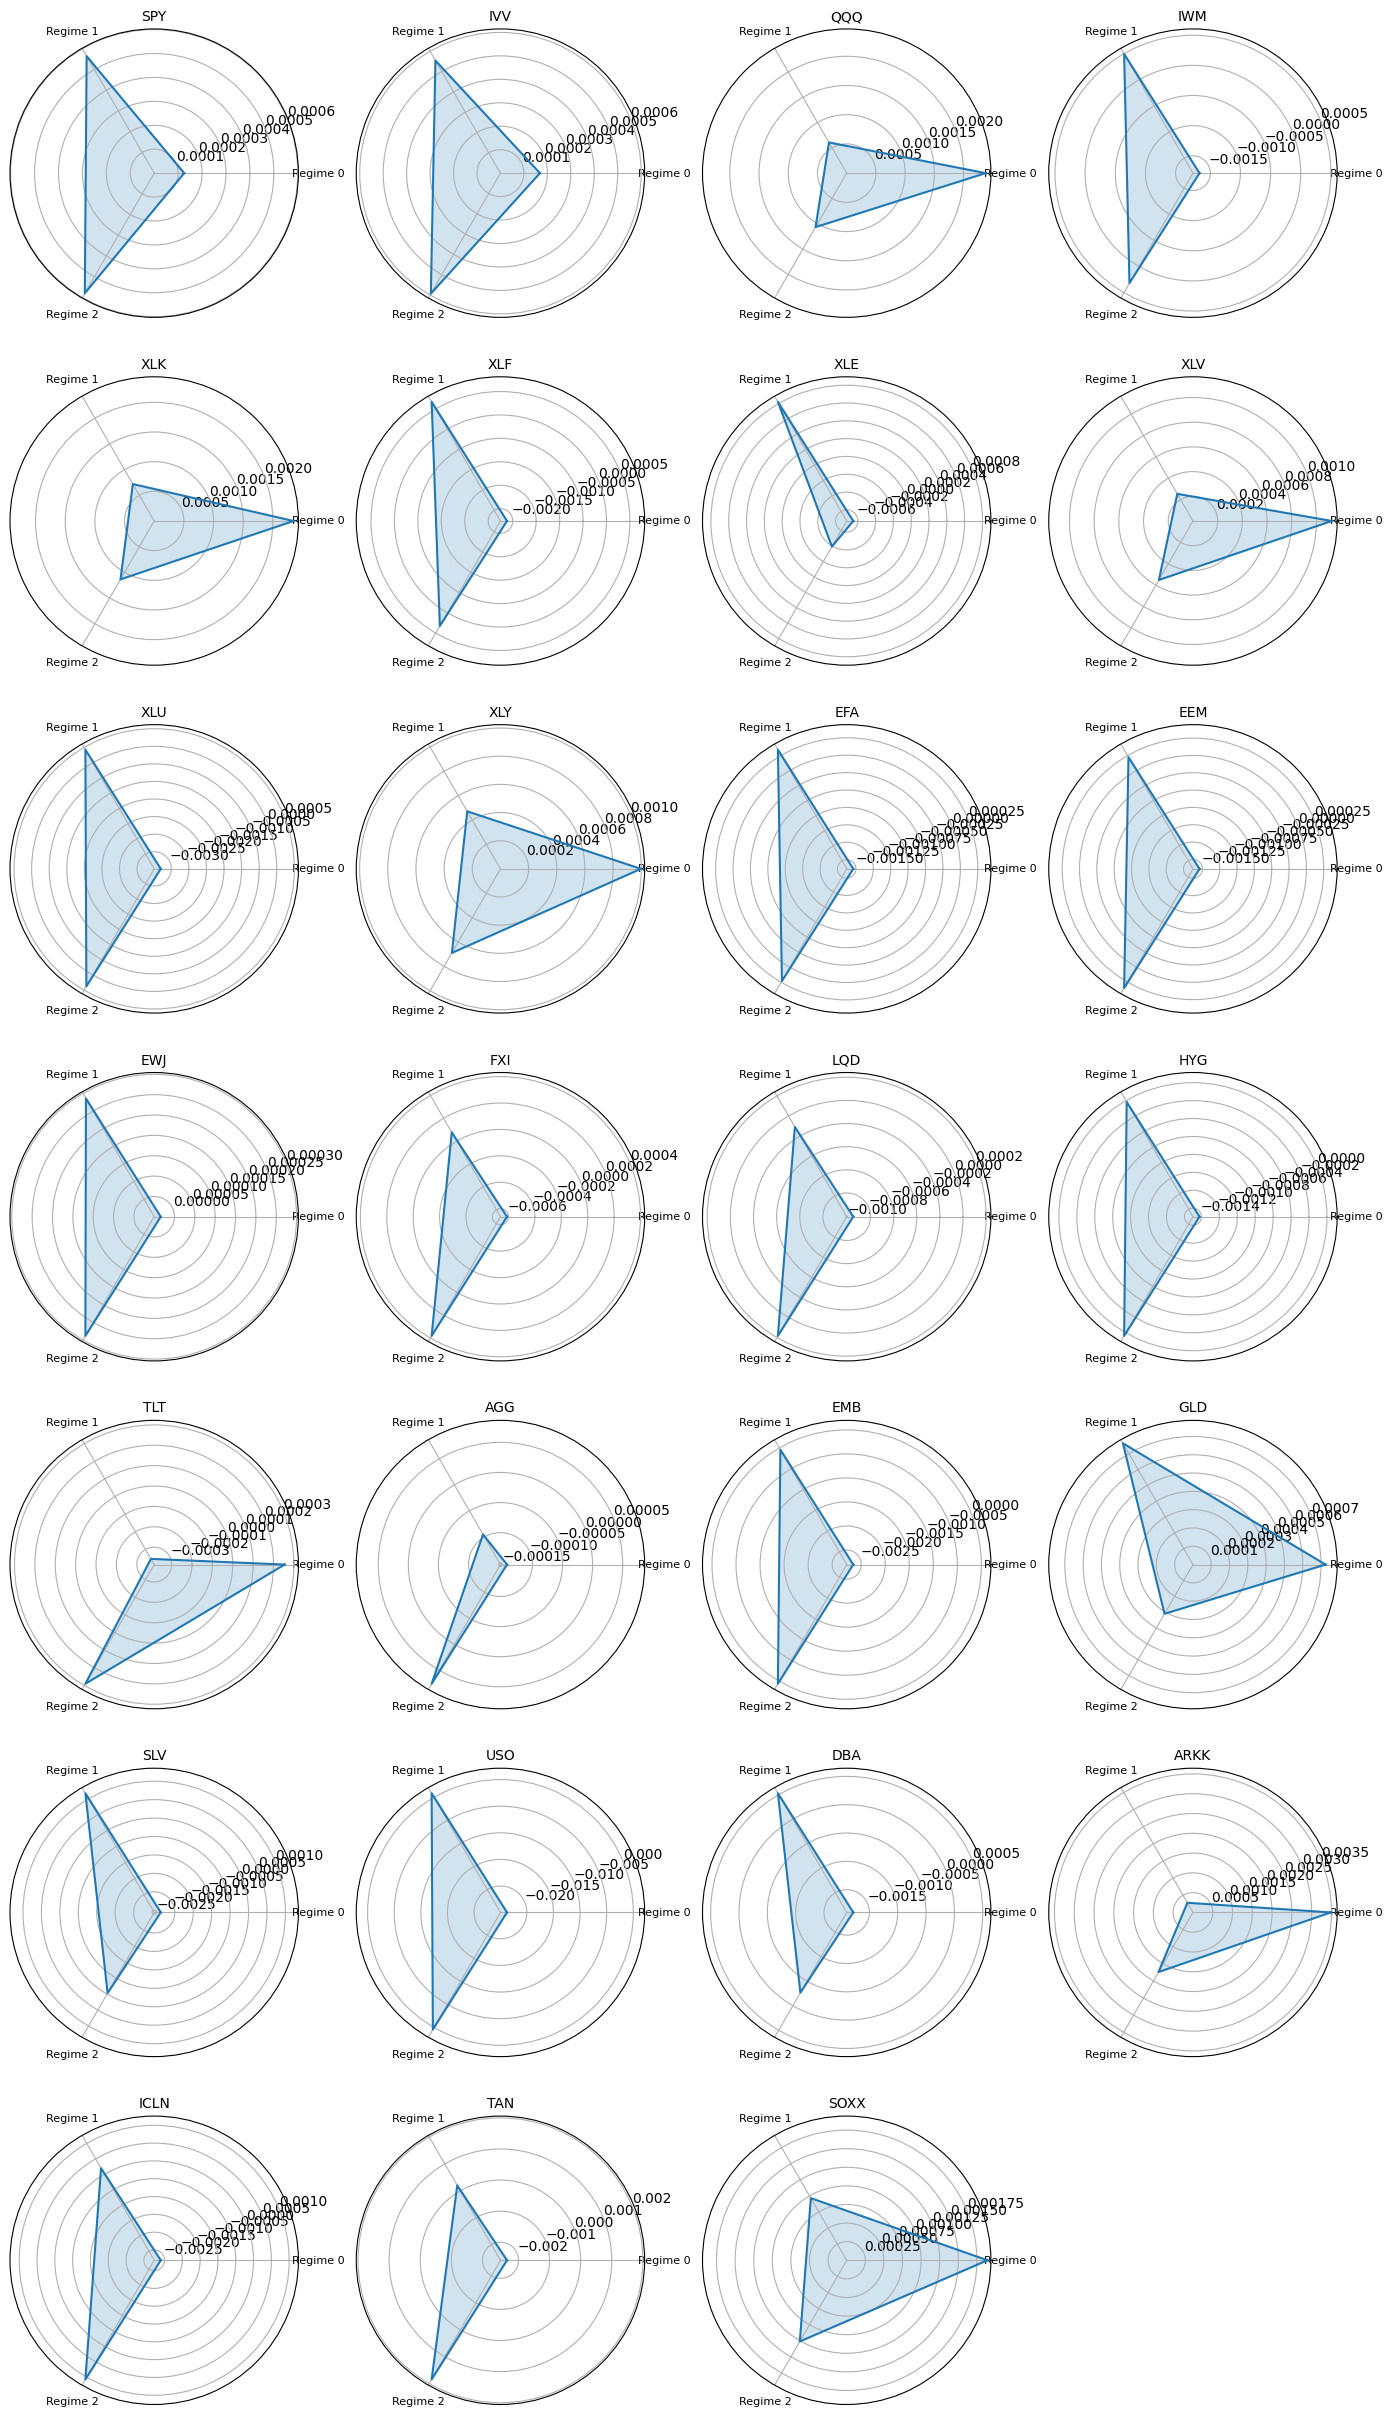

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def radar_plot(ax, values, etf):
    labels = ['Regime 0', 'Regime 1', 'Regime 2']
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    ax.plot(angles, values, linewidth=1.5)
    ax.fill(angles, values, alpha=0.2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_title(etf, fontsize=10)
    ax.grid(True)

etfs = list(returns.keys())
n = len(etfs)

cols = 4
rows = (n + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5), subplot_kw=dict(polar=True))
axes = axes.flatten()

for i, etf in enumerate(etfs):
    radar_plot(axes[i], returns[etf], etf)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
